In [1]:
import numpy as np
import data
from timeit import default_timer as timer

In [2]:
train = data.train
test = data.test

In [3]:
class MatrixFactorization():
    
    def __init__(self, train, test, f, epsilon):
        """
        param train : Rating Matrix for train
        param test : Rating Matrix for test
        param f : latent feature parameter
        """
        
        self._R = train # Implication Matrix for training size (m, n)
        self._R_test = test # Implication Matrix for test size (m, n)
        self._P = np.array(np.vectorize(lambda x: 0 if x==0 else 1)(train), dtype = np.float64) # Preference Matrix for training
        self._P_test = np.array(np.vectorize(lambda x: 0 if x==0 else 1)(test), dtype = np.float64) # Preference Matrix for training
        self._n_user_rated = np.sum(self._P, axis = 1)
        self._n_item_rated = np.sum(self._P, axis = 0)
        self._num_users, self._num_items = train.shape
        self._alpha = 1
        self._lambda = 0.01
        self._C = 1 + self._alpha * self._R # Confidence Matrix size (m, n)
        self._f = f
        self._epsilon = epsilon
        
        
    def fit(self):
        """
        training Matrix Factorization : update matrix latent weight and bias
        """
        # init latent features
        self._X = np.random.normal(0, 0.1, size=(self._num_users, self._f))
        self._Y = np.random.normal(0, 0.1, size=(self._num_items, self._f))
        
        count = 0
        cost_diff = 1000000
        self._training_process = []
        self._cost = [0]
        time = 0
        # repeat ALS until convergence
        while cost_diff > self._epsilon :
            
            start = timer()
            count += 1
            self._yTy = self._Y.T.dot(self._Y)
            for u in range(self._num_users):
                self.optimize_x(u)
            
            self._xTx = self._X.T.dot(self._X)
            for i in range(self._num_items):
                self.optimize_y(i)
            time += (timer() - start)
            
            cost = self.cost()
            self._cost.append(cost)
            if count > 1 :
                cost_diff = self._cost[count - 1] - self._cost[count]
            rank = self.compute_rank()
            self._training_process.append([count, cost_diff, rank])
            
            if (count % 10 == 0) :
                print("count: %d, cost_difference : %.4f, rank : %.4f, average time for a epoch : %.4f"% (count, cost_diff, rank, time / 10))
                time = 0
                
                
    def optimize_x(self, u):
        """
        Optimize X given user u
        """
        C_u = np.diag(self._C[u, :]) # create diagonal matrix size (n, n)
        
        # (f,f) matrix
        temp1 = self._yTy + self._Y.T.dot(C_u - np.identity(self._num_items)).dot(self._Y) + self._lambda * np.identity(self._f)
        # (f,1) matrix
        temp2 = self._Y.T.dot(C_u).dot(self._P[u])
        
        self._X[u, :] = np.linalg.inv(temp1).dot(temp2)
        
    
    def optimize_y(self, i):
        """
        Optimize X given user u
        """
        C_i = np.diag(self._C[:, i]) # create diagonal matrix size (m, m)
        
        # (f,f) matrix
        temp1 = self._xTx + self._X.T.dot(C_i - np.identity(self._num_users)).dot(self._X) + self._lambda * np.identity(self._f)
        # (f,1) matrix
        temp2 = self._X.T.dot(C_i).dot(self._P[:, i])
        
        self._Y[i, :] = np.linalg.inv(temp1).dot(temp2)
        
                
    def cost(self):
        """
        compute Loss function
        """
        loss = np.sum(self._C * np.square(self._P - self._X.dot(self._Y.T))) + self._lambda * (np.linalg.norm(self._X) + np.linalg.norm(self._Y))
        
        return loss
    
    
    def compute_rank(self):
        
        prediction = self._X.dot(self._Y.T)
        test_x = np.unique(self._R_test.nonzero()[0])
        temp_1 = 0
        temp_2 = 0
        
        for x in test_x :
            temp_y = self._R_test[x].nonzero()
            inv_pre = -1 * prediction[x, temp_y]
            sort_x = inv_pre.argsort() # index starts with 0
            sort_x = sort_x.argsort()
            rank_x = sort_x / len(sort_x[0])
            
            temp_1 += (self._R_test[x, temp_y] * rank_x).sum()
            temp_2 += self._R_test[x, temp_y].sum()
        
        rank = temp_1 / temp_2
            
        return rank
    
    
    def print_results(self):
        """
        print fit results
        """

        print("Final P hat matrix:")
        print(self._X.dot(self._Y.T))

In [4]:
np.random.seed(7)
    
np.seterr(all="warn")
    
factorizer = MatrixFactorization(train, test, f=40, epsilon = 1.0)
factorizer.fit()

count: 10, cost_difference : 120.1176, rank : 0.4689, average time for a epoch : 33.3757
count: 20, cost_difference : 16.9278, rank : 0.4689, average time for a epoch : 34.2047
count: 30, cost_difference : 5.8932, rank : 0.4688, average time for a epoch : 33.6196
count: 40, cost_difference : 3.0711, rank : 0.4688, average time for a epoch : 33.6040
count: 50, cost_difference : 1.7081, rank : 0.4688, average time for a epoch : 34.2292
count: 60, cost_difference : 0.9438, rank : 0.4688, average time for a epoch : 35.4069


데이터 셋의 한계점이 존재하는 듯  
cost_difference가 지속적으로 감소하는 것으로 봐서는, cost가 감소하면서 수렴하는 것으로 보임 (convex 함수이므로)  
rank measure가 0.47인 것은 매우 나쁜 수치  
저번주 implementation 중 좋은 성능을 보인 Constrained_pmf에 적용해보니, 0.45 수준에 수렴하는 것을 확인할 수 있었음

In [16]:
ind_list = []
drop_list = []
rank_list = []

for i in range(1, len(factorizer._training_process)):
    ind_list.append(factorizer._training_process[i][0])
    drop_list.append(factorizer._training_process[i][1])
    rank_list.append(factorizer._training_process[i][2])

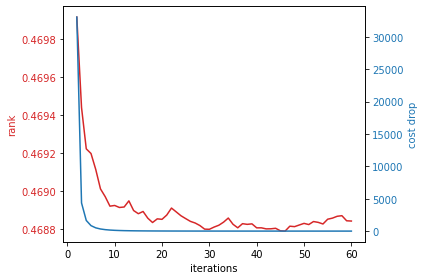

In [26]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('iterations')
ax1.set_ylabel('rank', color=color)
ax1.plot(ind_list, rank_list, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('cost drop', color=color)  # we already handled the x-label with ax1
ax2.plot(ind_list, drop_list, color=color)
ax2.tick_params(axis='y', labelcolor=color)


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()